In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wsi.utils import processed_data_path, raw_data_path
from wsi.mapping.iso_name import ISO_NAME

index_baseline = pd.read_csv(processed_data_path("womens_safety_index_baseline_only_incl.csv"))
path = raw_data_path("violence", "WorldBank_GenderStatistics_IntimatePartner.csv")
df = pd.read_csv(path)
df = df.iloc[:530, :] # delete trailing na rows

# DHS IPV data
SG.VAW.IPVE.ZS
Proportion of women who have ever experienced intimate partner violence (% of ever-married women ages 15-49)

In [2]:
df['Series Code'].unique()

array(['SG.VAW.1549.LT.ME.ZS', 'SG.VAW.IPVE.ZS'], dtype=object)

In [3]:
df_filtered = df[df['Series Code'] == 'SG.VAW.IPVE.ZS']

# for modelled estimate
df_filtered = df[df['Series Code'] == 'SG.VAW.1549.LT.ME.ZS']
df_pivot = df_filtered.set_index('Country Code').drop(columns=['Series Name', 'Series Code', 'Country Name'])
df_pivot.columns = df_pivot.columns.str.extract(r'(\d{4})')[0].astype(int)
df_pivot = df_pivot.reset_index()  # Make Country Code a column
df_long = df_pivot.melt(id_vars='Country Code', var_name='Year', value_name='IPV').rename(columns={'Country Code':'ISO_code'})

# for modelled estimate
df_long = df_long[df_long['Year']==2018]
df_long.head()

,ISO_code,Year,IPV
15370,AFG,2018,46.0
15371,ALB,2018,13.0
15372,DZA,2018,NaN
15373,ASM,2018,NaN
15374,AND,2018,NaN


In [4]:
merged = pd.merge(df_long, index_baseline,
                  on=['ISO_code', 'Year'],
                  how='inner')
merged = merged.dropna(subset=['IPV'])

merged['IPV']  = pd.to_numeric(merged['IPV'],  errors='coerce')
merged['Year'] = pd.to_numeric(merged['Year'], errors='coerce')
merged = merged.dropna(subset=['IPV', "WSI (Baseline)"])
merged.head()

,ISO_code,Year,IPV,Education,Employment,Parliamentary Representation,Poverty,Legal Protection Index,Son Bias,Maternal Mortality,...,Water Sanitation Access (score),Electricity Access (score),Cell Phone Use (score),Financial Inclusion (score),Equity,Protection,Resources,WSI (Baseline),included_index,Economy
0,AFG,2018,46.0,0.448699,18.845366,27.444795,24.6897,0.229167,105.3,663.42750,...,0.525649,0.933468,0.187532,0.054020,30.036453,70.064615,42.516712,44.726923,True,Afghanistan
1,ALB,2018,13.0,0.938384,61.251300,27.857143,0.0000,0.937500,108.4,5.42929,...,0.972558,1.000000,0.295419,0.390069,67.680200,81.364931,66.451133,71.526520,True,Albania
3,AGO,2018,38.0,0.603410,67.993270,30.454545,31.1000,0.812500,102.6,233.09626,...,0.488122,0.448589,0.133023,0.217101,54.607569,71.563854,32.170850,50.095998,True,Angola
5,ARG,2018,27.0,1.038603,61.964635,39.513678,1.0000,0.687500,105.3,33.94483,...,0.958828,1.000000,0.413044,0.539713,66.159193,84.769420,72.789618,74.182184,True,Argentina
6,ARM,2018,10.0,0.998816,59.338195,18.095238,1.3000,0.812500,110.8,25.10140,...,0.953746,0.998992,0.395031,0.413325,63.458711,82.173729,69.027352,71.134752,True,Armenia


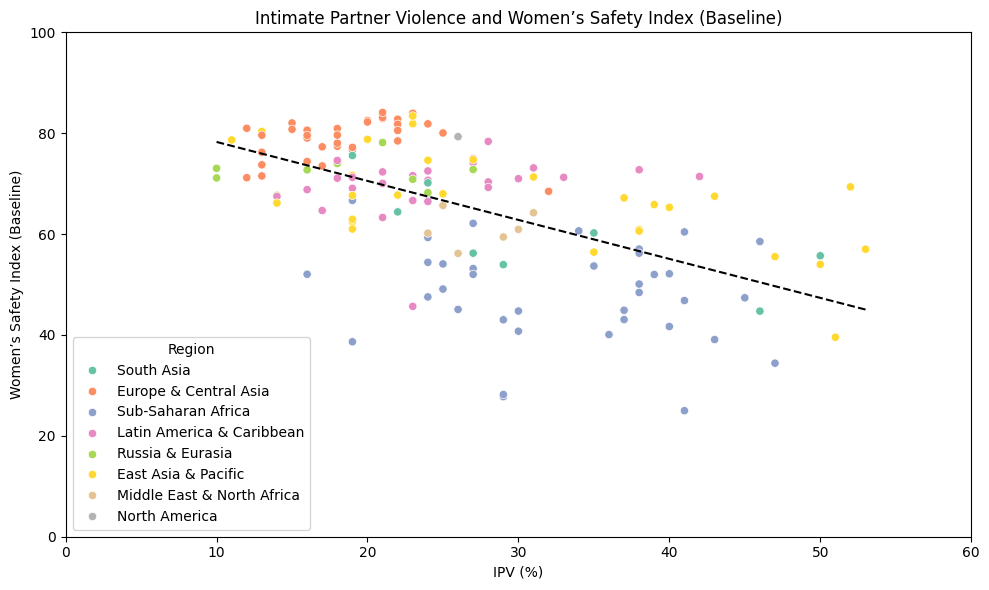

In [5]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=merged,
    x='IPV',
    y='WSI (Baseline)',
    hue='Region',
    palette='Set2',  # or use another palette like 'Set2', 'Dark2', etc.
    alpha=1
)

# Linear fit
m, b = np.polyfit(merged['IPV'], merged['WSI (Baseline)'], 1)
x = np.array([merged['IPV'].min(), merged['IPV'].max()])
plt.plot(x, m * x + b, linestyle='--', color='black', label=f'Fit: y={m:.2f}x+{b:.1f}')

plt.xlabel('IPV (%)')
plt.ylabel("Women’s Safety Index (Baseline)")
plt.title('Intimate Partner Violence and Women’s Safety Index (Baseline)')
#plt.legend()

plt.xlim(0, 60)
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('../imgs/homepage_IPV_vs_WSI_baseline.png', dpi=300)


In [6]:

merged.to_csv(processed_data_path("2918_ipv_wsi.csv"), index=False)

In [7]:
ipv_avg = (
    df_long
    .assign(IPV=lambda df: pd.to_numeric(df['IPV'], errors='coerce'))
    .dropna(subset=['IPV'])
    .groupby('ISO_code', as_index=False)['IPV']
    .mean()
    .rename(columns={'IPV': 'Avg_IPV'})
)

wsi_avg = (
    index_baseline
    .assign(WSI=lambda df: pd.to_numeric(df["WSI (Baseline)"], errors='coerce'))
    .dropna(subset=['WSI'])
    .groupby('ISO_code', as_index=False)['WSI']
    .mean()
    .rename(columns={'WSI': 'Avg_WSI'})
)

summary = pd.merge(ipv_avg, wsi_avg, on='ISO_code', how='inner')
summary["Economy"] = summary["ISO_code"].map(ISO_NAME)
summary.head()

,ISO_code,Avg_IPV,Avg_WSI,Economy
0,AFG,46.0,34.800154,Afghanistan
1,AGO,38.0,46.616533,Angola
2,ALB,13.0,66.106978,Albania
3,ARG,27.0,70.679749,Argentina
4,ARM,10.0,64.311104,Armenia


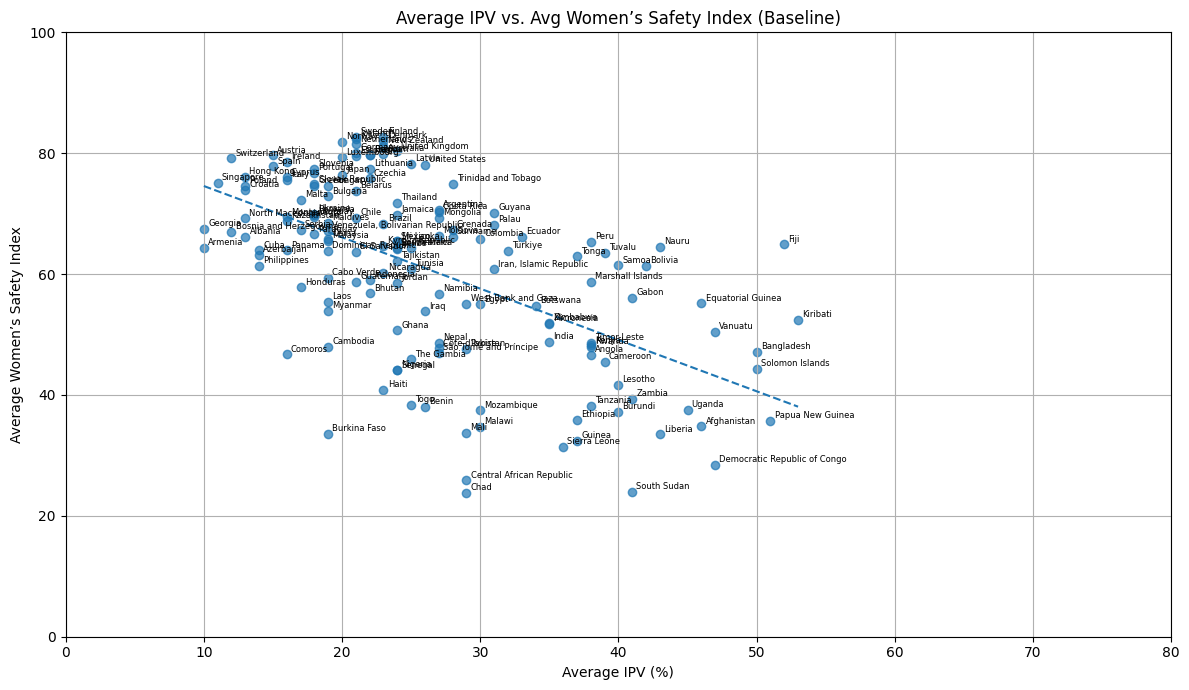

In [8]:
plt.figure(figsize=(12, 7))
plt.scatter(summary['Avg_IPV'], summary['Avg_WSI'], alpha=0.7)

for _, row in summary.iterrows():
    plt.annotate(
        row['Economy'],
        (row['Avg_IPV'], row['Avg_WSI']),
        textcoords="offset points",
        xytext=(3, 2),
        ha='left',
        fontsize=6
    )

# plot the fit line
x_vals = np.array([summary['Avg_IPV'].min(), summary['Avg_IPV'].max()])
m, b = np.polyfit(summary['Avg_IPV'], summary['Avg_WSI'], 1)
plt.plot(x_vals, m * x_vals + b, linestyle='--',
         label=f'Fit: y = {m:.2f}x + {b:.1f}')

plt.xlabel('Average IPV (%)')
plt.ylabel('Average Women’s Safety Index')
plt.title('Average IPV vs. Avg Women’s Safety Index (Baseline)')
#plt.legend()
plt.grid(True)
plt.xlim(0, 80)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

In [9]:
merged

,ISO_code,Year,IPV,Education,Employment,Parliamentary Representation,Poverty,Legal Protection Index,Son Bias,Maternal Mortality,...,Water Sanitation Access (score),Electricity Access (score),Cell Phone Use (score),Financial Inclusion (score),Equity,Protection,Resources,WSI (Baseline),included_index,Economy
0,AFG,2018,46.0,0.448699,18.845366,27.444795,24.6897,0.229167,105.3,663.42750,...,0.525649,0.933468,0.187532,0.054020,30.036453,70.064615,42.516712,44.726923,True,Afghanistan
1,ALB,2018,13.0,0.938384,61.251300,27.857143,0.0000,0.937500,108.4,5.42929,...,0.972558,1.000000,0.295419,0.390069,67.680200,81.364931,66.451133,71.526520,True,Albania
3,AGO,2018,38.0,0.603410,67.993270,30.454545,31.1000,0.812500,102.6,233.09626,...,0.488122,0.448589,0.133023,0.217101,54.607569,71.563854,32.170850,50.095998,True,Angola
5,ARG,2018,27.0,1.038603,61.964635,39.513678,1.0000,0.687500,105.3,33.94483,...,0.958828,1.000000,0.413044,0.539713,66.159193,84.769420,72.789618,74.182184,True,Argentina
6,ARM,2018,10.0,0.998816,59.338195,18.095238,1.3000,0.812500,110.8,25.10140,...,0.953746,0.998992,0.395031,0.413325,63.458711,82.173729,69.027352,71.134752,True,Armenia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,VEN,2018,19.0,1.057884,60.602692,22.155689,7.1000,0.781250,105.7,179.33174,...,0.951033,0.998992,0.217602,0.721912,63.542236,78.816418,72.238483,71.255097,True,"Venezuela, Bolivarian Republic"
185,VNM,2018,25.0,0.916008,85.821381,26.720648,1.2000,0.843750,114.8,51.06105,...,0.871690,1.000000,0.463878,0.335285,70.030143,67.172602,66.771319,67.976017,True,Vietnam
186,PSE,2018,29.0,0.978193,14.592028,13.072237,0.5000,0.281250,105.1,20.95697,...,0.973368,1.000000,0.281679,0.176544,41.533229,83.136890,60.789790,59.430133,True,West Bank and Gaza
188,ZMB,2018,41.0,0.759402,61.083705,17.964072,62.3000,0.812500,101.1,144.87115,...,0.401958,0.397177,0.271539,0.261892,46.516857,66.256112,33.314169,46.826148,True,Zambia
